### Laboratorium 5 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [18]:
!pip install scikit-image

In [19]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from skimage.util import img_as_float

#### Zadanie 1 (1.0 pkt | 1.0 pkt)

Dany jest obraz `hare`. Wykonaj dla niego segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie takich superpikseli, które zawierają tylko fragmenty zająca, lub tylko fragmenty trawy (a nie jedno i drugie naraz). Sprawdź zachowanie algorytmu dla różnej liczby superpikseli.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja `mark_boundaries`.

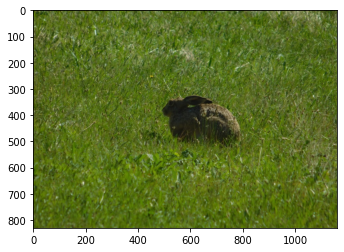

In [20]:
hare = cv2.imread('Zajac_kolor.jpg')[..., ::-1]
plt.imshow(hare);

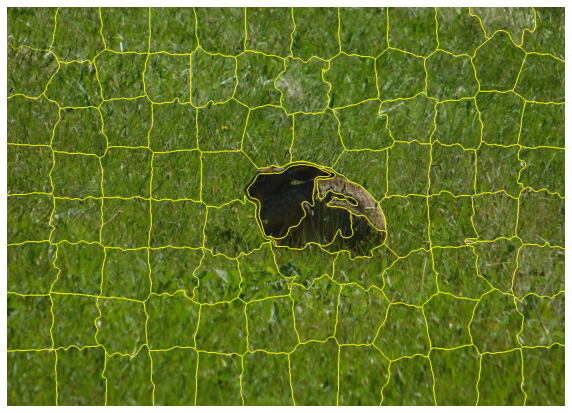

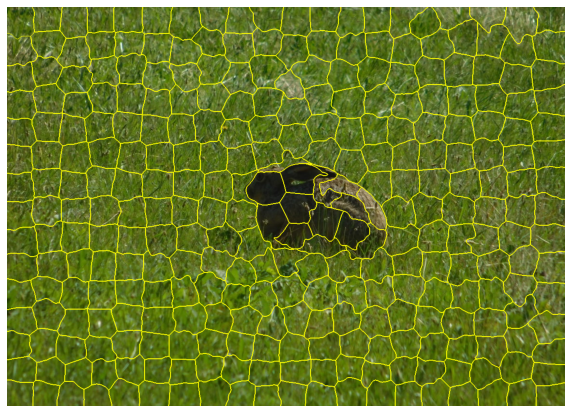

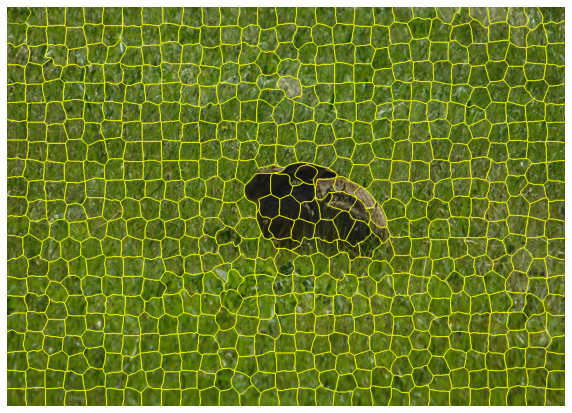

In [21]:
image = img_as_float(cv2.cvtColor(hare, cv2.COLOR_BGR2RGB))

# Pętla po liczbie klastrów:
for numSegments in (100, 300, 600):
    
# Wywołanie algorytmu SLIC:
    segments = slic(image, n_segments = numSegments, sigma = 5, start_label = 0, compactness=15)
    
# prezentacja wyników:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1)
    img_tmp = mark_boundaries(hare, segments)
    ax.imshow(img_tmp) 
    plt.axis("off")

#### Zadanie 2 (2.0 pkt | 1.0 pkt)

Wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. `cv2.kmeans`) używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Zawsze możesz rozszerzyć rozwiązanie o bardziej wyrafinowane pomysły, jeśli starczy czasu.  
Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [22]:
from sklearn.preprocessing import StandardScaler

def convert_segments(img, segments):
    no_seg = np.max(segments)+1
    data_arr = np.zeros((no_seg, 3))
    for i in range(no_seg):
        filtered = img[segments==i]
        means = np.mean(filtered, axis=0)
        # varis = np.var(filtered, axis=0)
        data_arr[i][0:3] = means
        # data_arr[i][3:6] = varis
    return StandardScaler().fit_transform(data_arr)

In [29]:
segments = slic(image, n_segments = 300, sigma = 4, start_label = 0, compactness=15)
data = convert_segments(cv2.cvtColor(hare, cv2.COLOR_BGR2LAB), segments)
c, labels, centers = cv2.kmeans(
    data=data.astype(np.float32),  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=50, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
data.shape

(299, 3)

Możesz wykorzystać poniższy snippet by zredukować wynik segmentacji SLIC (`segments`) w oparciu o klasteryzację k-średnich (`labels`):

(-0.5, 1159.5, 829.5, -0.5)

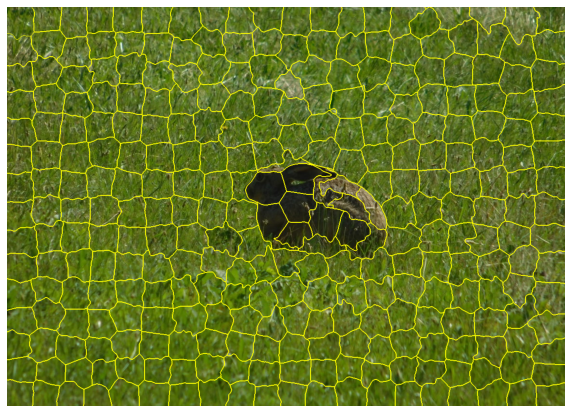

In [30]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
img_tmp = mark_boundaries(hare, segments)
ax.imshow(img_tmp) 
plt.axis("off")

(-0.5, 1159.5, 829.5, -0.5)

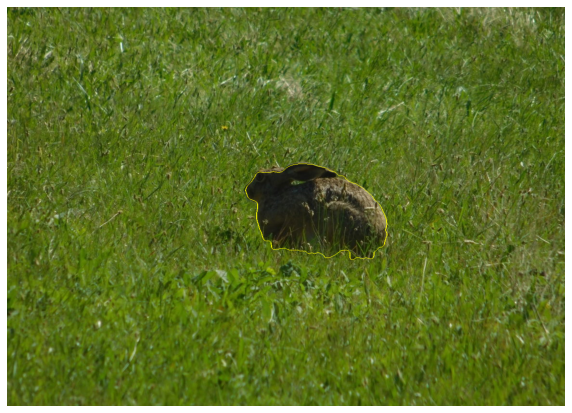

In [31]:
postprocessed = np.zeros_like(segments)
for i in range(labels.shape[0]):
    postprocessed[segments==i] = labels[i] # jeśli używamy indeksowania od 0 w SLIC
    # postprocessed[segments==i+1] = labels[i] # jeśli używamy indeksowania od 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
img_tmp = mark_boundaries(hare, postprocessed)
ax.imshow(img_tmp) 
plt.axis("off")